In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd 
import sys 
sys.path.append("/Odyssey/private/t22picar/tools/")
from plot_tools import plot_uv_map,plot_map_zoom,plot_map_multizoom

In [2]:
# Select geostrophy and product 

time_target='2019-10-27'

box_cal = [-175, -115, 20, 70]
box_med = [-5.6, 16.8, 34.6, 44.6]
box_gs = [-80, 0, 30, 60 ]
box_agulhas = [0, 60, -50, -30]
box_NA = [-40, 0, 48, 68]

box_mozemb = [30, 54,-35, -6]
box_kuro = [125, 170, 25, 45]

In [3]:
# Year mean 
from glob import glob 

list_of_maps = sorted(glob("/Odyssey/private/t22picar/multivar_drifter/rec/unet_uv_aoml_15m_10y_11d_bathy_no_sst_mae_duacs_RonanUnet/daily/unet_rec_*.nc"))
imt = xr.open_mfdataset(list_of_maps, combine='nested', concat_dim='time').sel(time=time_target).isel(lat=slice(2, -2))

list_of_maps = "/Odyssey/private/t22picar/data/uv/GC_daily/Ekman/globcurrent_15m_ekman_2019.nc"
gc_ek = xr.open_dataset(list_of_maps).isel(depth=0).isel(time=slice(None, -1)).drop_vars("depth")
gc_ek = gc_ek.rename({"longitude":"lon"})
gc_ek = gc_ek.rename({"latitude":"lat"})
gc_ek = gc_ek.transpose('time','lat','lon')
ec_gc_ek = (gc_ek.ue**2 + gc_ek.ve**2).compute()
##gc_ek = gc_ek.interp(lon=imt.lon,lat=imt.lat,method="linear")

list_of_maps = sorted(glob("/Odyssey/private/t22picar/multivar_drifter/rec/globcurrent_15m_4th/daily/unet_rec_*.nc"))
gc = xr.open_mfdataset(list_of_maps, combine='nested', concat_dim='time').astype("float32")
ec_gc = (gc.ugos**2 + gc.vgos**2).compute()

list_of_maps = sorted(glob("/Odyssey/private/t22picar/multivar_drifter/rec/globcurrent_15m_4th/daily/unet_rec_*.nc"))
gc = xr.open_mfdataset(list_of_maps, combine='nested', concat_dim='time').astype("float32")
ec_gc = (gc.ugos**2 + gc.vgos**2).compute()
#gc = gc.interp(lon=gc_ek.lon,lat=gc_ek.lat,method="linear")


In [4]:
list_of_maps = sorted(glob("/Odyssey/private/t22picar/multivar_drifter/rec/duacs_15m_8th/daily/duacs_15m_8th_*.nc"))
duacs = xr.open_mfdataset(list_of_maps, combine='nested', concat_dim='time')
duacs = duacs.rename({"longitude":"lon"})
duacs = duacs.rename({"latitude":"lat"})
duacs = duacs.interp(lon=ec_gc.lon,lat=ec_gc.lat,method="linear")
ec_duacs = (duacs.ugos**2 + duacs.vgos**2).compute()

In [5]:
#ek_dom = (ec_gc_ek / ec_gc)*100
ek_dom = (ec_gc_ek / ec_duacs)
# Remplacer les inf par NaN
ek_dom = ek_dom.where(~np.isinf(ek_dom), np.nan)

In [ ]:
ek_dom_mean = ek_dom.mean(dim="time",skipna=True)


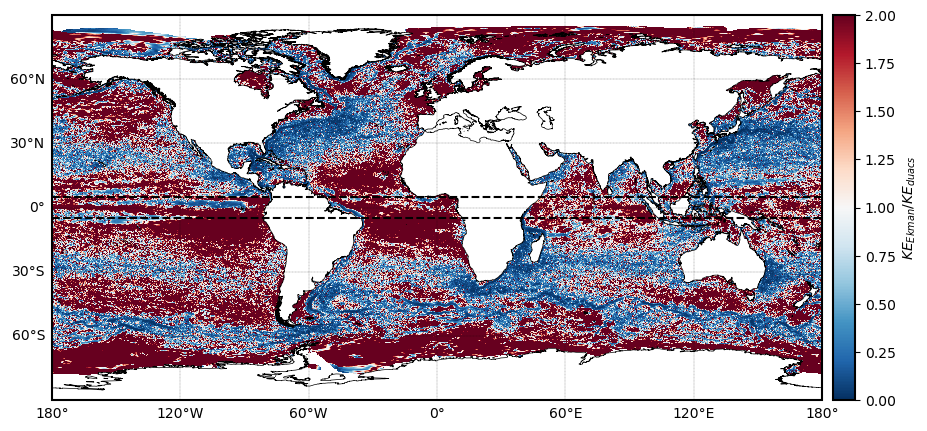

In [24]:
vmax=2
plot_uv_map(ek_dom_mean,ek_dom.lon,ek_dom.lat,lat_mask=5,vmin=0,vmax=vmax,colorbar_title="$KE_{Ekman} / KE_{duacs}$")

In [29]:
# Assuming ek_dom_mean is your xarray DataArray or Dataset
ek_dom_mean.to_netcdf('ek_dom_mean.nc')

In [30]:
ek_dom_mean

<xarray.DataArray (lat: 720, lon: 1440)> Size: 8MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float32 3kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 6kB -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9

In [25]:
# Exemple avec coarsen (bins réguliers de taille 2)
binned_mean = ek_dom_mean.coarsen(lat=3, lon=3, boundary='trim').mean(skipna=True)

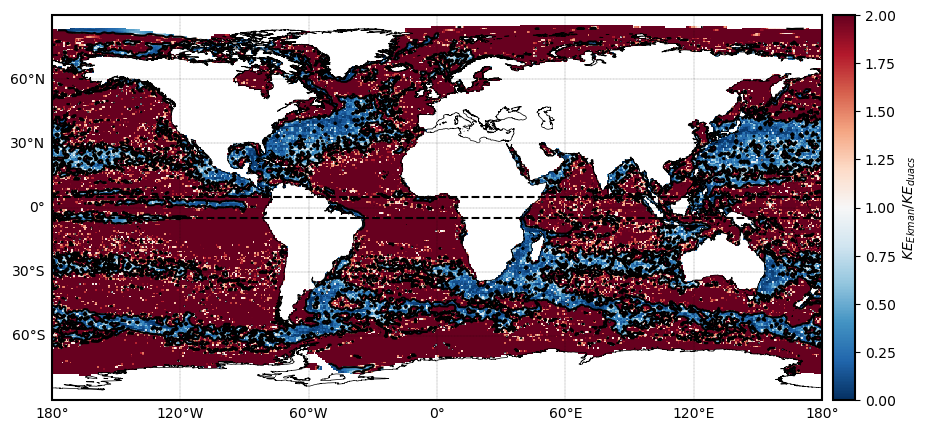

In [26]:
# Compare map 
import cartopy.crs as ccrs
fig, axs = plt.subplots(nrows=1,ncols=1,
                    subplot_kw={'projection': ccrs.PlateCarree()},
                    figsize=(11*1,5*1))


plot_uv_map(binned_mean,binned_mean.lon,binned_mean.lat,lat_mask=5,vmin=0,vmax=vmax,colorbar_title="$KE_{Ekman} / KE_{duacs}$",cmap=plt.cm.RdBu_r,fig=fig,axs=axs)
axs.contour(binned_mean.lon,binned_mean.lat,binned_mean,colors='k',levels=[1])

In [5]:
# Compute cyclogeos from duacs 

list_of_maps = sorted(glob("/Odyssey/private/t22picar/multivar_drifter/rec/duacs_15m_8th/daily/duacs_15m_8th_*.nc"))
duacs = xr.open_mfdataset(list_of_maps, combine='nested', concat_dim='time').sel(time=time_target)
duacs = duacs.rename({"longitude":"lon"})
duacs = duacs.rename({"latitude":"lat"})
duacs = duacs.interp(lon=ec_imt.lon,lat=ec_imt.lat,method="linear")

lon = duacs.lon.values
lat = duacs.lat.values
lon2D, lat2D = np.meshgrid(lon, lat)

In [ ]:
from jaxparrow import cyclogeostrophy, geostrophy

(u_geo,v_geo,lat_u, lon_u, lat_v, lon_v) = geostrophy(duacs.adt.values, lat2D, lon2D)

#(u_geo,v_geo,lat_u, lon_u, lat_v, lon_v) = cyclogeostrophy(duacs.adt.values, lat2D, lon2D)

: 

In [6]:
# U - Ucyclo 
U_ekman = imt.ugos - u_geo

NameError: name 'u_geo' is not defined

In [ ]:
# Compare map 
plot_map_multizoom(U_ekman,imt.lon,imt.lat,lat_mask=5,vmin=-vmax,vmax=vmax,colorbar_label="$KE_{Ekman}$",list_zoom_ax=list_zoom_ax,list_zoom_extent=list_zoom_extent)

: 

In [ ]:
# Sélectionner les latitudes > 10° ou < -10°
U_ekman_no_eq = U_ekman.sel(lat=((U_ekman.lat > 10) | (U_ekman.lat < -10)))
U_ekmanGC_no_eq = gc.ue.sel(lat=((gc.lat > 10) | (gc.lat < -10)))

: 

In [ ]:
# Calculer la corrélation le long de l'axe temporel (time)
correlations = xr.corr(U_ekman_no_eq, U_ekmanGC_no_eq)
correlations.values

: 

Correlation map 2019

In [3]:
# Year mean 
from glob import glob 

list_of_maps = sorted(glob("/Odyssey/private/t22picar/multivar_drifter/rec/unet_uv_aoml_15m_10y_11d_bathy_no_sst_mae_duacs_RonanUnet/daily/unet_rec_*.nc"))
imt = xr.open_mfdataset(list_of_maps, combine='nested', concat_dim='time').isel(lat=slice(4, -4)).isel(lon=slice(4, -4))
ec_imt = (imt.ugos**2 + imt.vgos**2)/2

list_of_maps = "/Odyssey/private/t22picar/data/uv/GC_daily/Ekman/globcurrent_15m_ekman_2019.nc"
gc = xr.open_dataset(list_of_maps).isel(depth=0)
gc = gc.rename({"longitude":"lon"})
gc = gc.rename({"latitude":"lat"})
#gc = gc.transpose('time','lat','lon')
gc = gc.interp(lon=ec_imt.lon,lat=ec_imt.lat,method="linear")

In [4]:
# DUACS GEOS

list_of_maps = sorted(glob("/Odyssey/private/t22picar/multivar_drifter/rec/duacs_15m_8th/daily/duacs_15m_8th_*.nc"))
duacs = xr.open_mfdataset(list_of_maps, combine='nested', concat_dim='time')
duacs = duacs.rename({"longitude":"lon"})
duacs = duacs.rename({"latitude":"lat"})
duacs = duacs.interp(lon=ec_imt.lon,lat=ec_imt.lat,method="linear")


In [8]:
duacs_mean = duacs.mean(dim='time').compute()
imt_mean = imt.mean(dim='time').compute()

In [12]:

diff_mean_u =  imt_mean.ugos - duacs_mean.ugos
diff_mean_v =  imt_mean.vgos - duacs_mean.vgos

Text(0.02, 1.08, 'b')

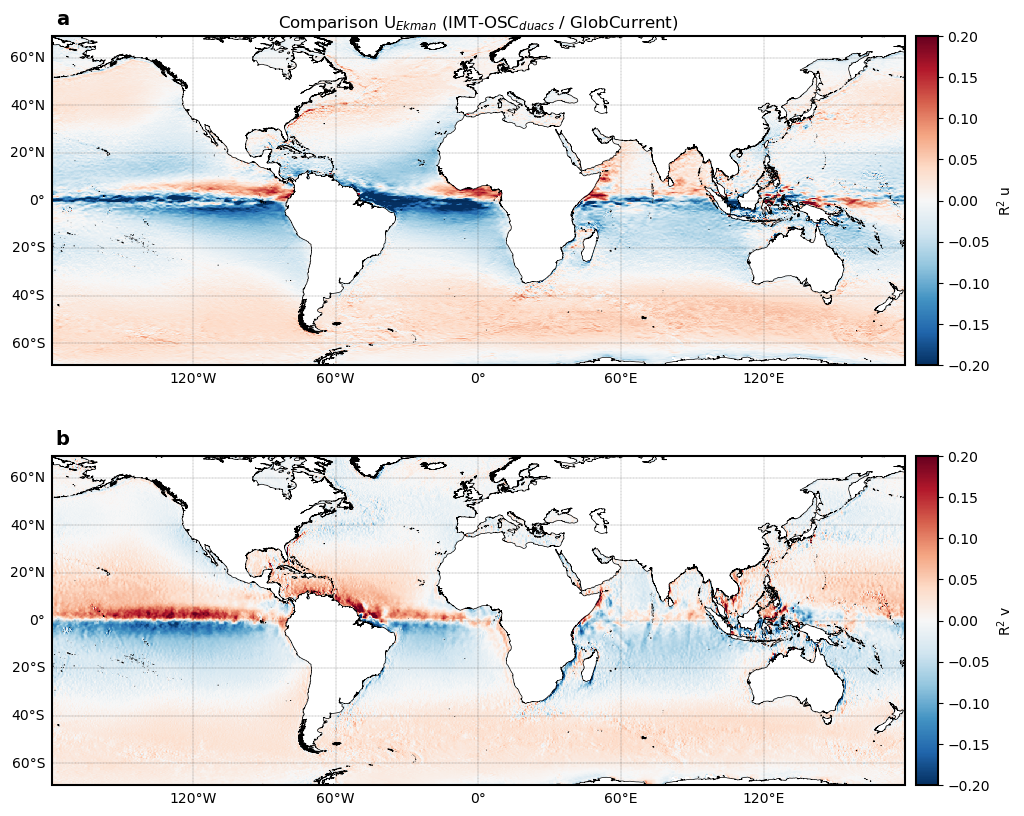

In [15]:
# Compare map 
import cartopy.crs as ccrs
fig, axs = plt.subplots(nrows=2,ncols=1,
                    subplot_kw={'projection': ccrs.PlateCarree()},
                    figsize=(11*1,5*2))

plot_uv_map(diff_mean_u,imt.lon,imt.lat,lat_mask=None,vmin=-0.2,vmax=0.2,colorbar_title="R$^{2}$ u",title="Comparison U$_{Ekman}$ (IMT-OSC$_{duacs}$ / GlobCurrent)",cmap=plt.cm.RdBu_r,fig=fig,axs=axs[0])
axs[0].text(0.02, 1.08, "a", transform=axs[0].transAxes, fontsize=14, fontweight='bold', va='top', ha='right', bbox=dict(facecolor='none', alpha=0.7, edgecolor='none'))
plot_uv_map(diff_mean_v,imt.lon,imt.lat,lat_mask=None,vmin=-0.2,vmax=0.2,colorbar_title="R$^{2}$ v",cmap=plt.cm.RdBu_r,fig=fig,axs=axs[1])
axs[1].text(0.02, 1.08, "b", transform=axs[1].transAxes, fontsize=14, fontweight='bold', va='top', ha='right', bbox=dict(facecolor='none', alpha=0.7, edgecolor='none'))

In [18]:
# U - Ugeo
U_ekman = imt.ugos - duacs.ugos - diff_mean_u
# Calculer la corrélation le long de l'axe temporel (time)
correlations_u = xr.corr(U_ekman, gc.ue, dim='time').compute()

# U - Ugeo
V_ekman = imt.vgos - duacs.vgos - diff_mean_v
# Calculer la corrélation le long de l'axe temporel (time)
correlations_v = xr.corr(V_ekman, gc.ve, dim='time').compute()


Text(0.02, 1.08, 'b')

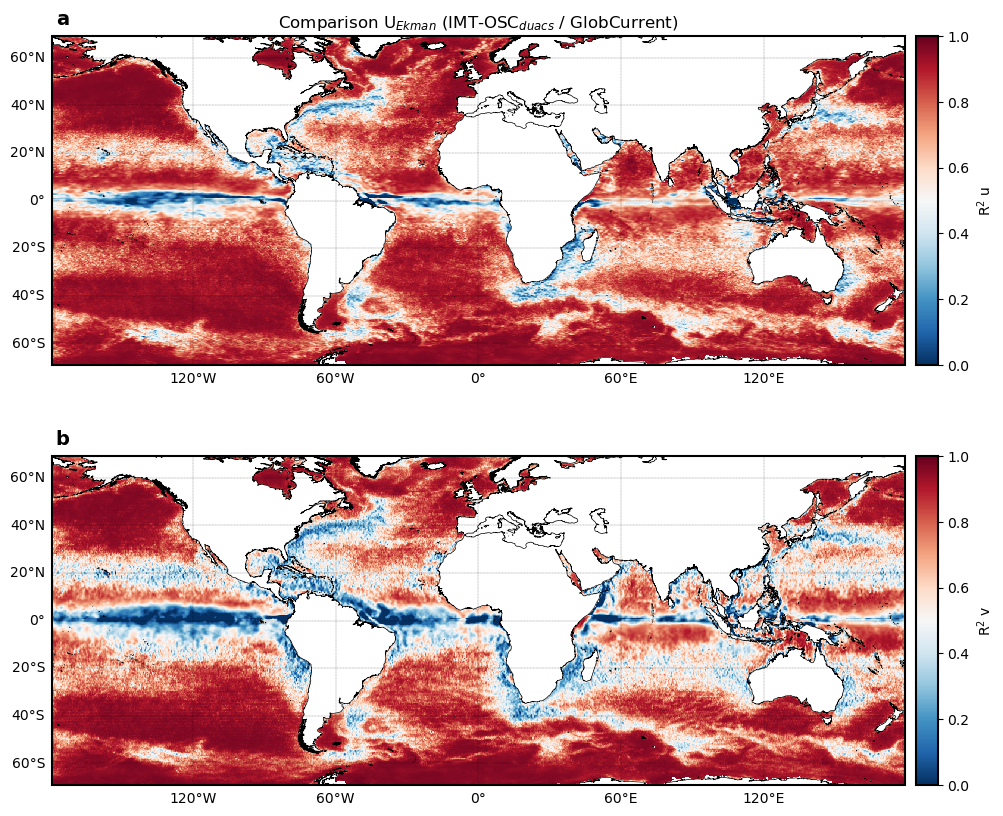

In [19]:

# Compare map 
import cartopy.crs as ccrs
fig, axs = plt.subplots(nrows=2,ncols=1,
                    subplot_kw={'projection': ccrs.PlateCarree()},
                    figsize=(11*1,5*2))

plot_uv_map(correlations_u,imt.lon,imt.lat,lat_mask=None,vmin=0,vmax=1,colorbar_title="R$^{2}$ u",title="Comparison U$_{Ekman}$ (IMT-OSC$_{duacs}$ / GlobCurrent)",cmap=plt.cm.RdBu_r,fig=fig,axs=axs[0])
axs[0].text(0.02, 1.08, "a", transform=axs[0].transAxes, fontsize=14, fontweight='bold', va='top', ha='right', bbox=dict(facecolor='none', alpha=0.7, edgecolor='none'))
plot_uv_map(correlations_v,imt.lon,imt.lat,lat_mask=None,vmin=0,vmax=1,colorbar_title="R$^{2}$ v",cmap=plt.cm.RdBu_r,fig=fig,axs=axs[1])
axs[1].text(0.02, 1.08, "b", transform=axs[1].transAxes, fontsize=14, fontweight='bold', va='top', ha='right', bbox=dict(facecolor='none', alpha=0.7, edgecolor='none'))
#plt.savefig(f"../figures/Figure_ekman.png", dpi = 300,bbox_inches='tight')

In [ ]:
# U - Ugeo
U_ekman = imt.ugos - duacs.ugos #+ diff_mean_u
# Calculer la corrélation le long de l'axe temporel (time)
correlations_u = xr.corr(U_ekman, gc.ue, dim='time')

# U - Ugeo
V_ekman = imt.vgos - duacs.vgos #+ diff_mean_v
# Calculer la corrélation le long de l'axe temporel (time)
correlations_v = xr.corr(V_ekman, gc.ve, dim='time')

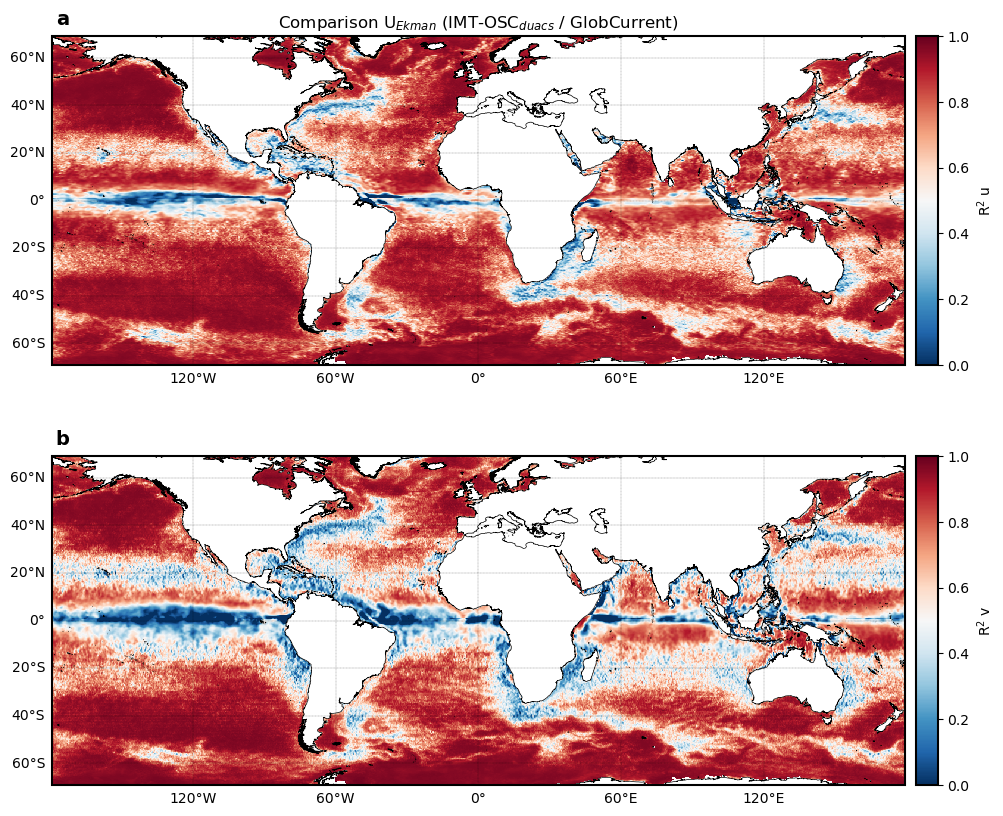

In [33]:
# Compare map 
import cartopy.crs as ccrs
fig, axs = plt.subplots(nrows=2,ncols=1,
                    subplot_kw={'projection': ccrs.PlateCarree()},
                    figsize=(11*1,5*2))

plot_uv_map(correlations_u,imt.lon,imt.lat,lat_mask=None,vmin=0,vmax=1,colorbar_title="R$^{2}$ u",title="Comparison U$_{Ekman}$ (IMT-OSC$_{duacs}$ / GlobCurrent)",cmap=plt.cm.RdBu_r,fig=fig,axs=axs[0])
axs[0].text(0.02, 1.08, "a", transform=axs[0].transAxes, fontsize=14, fontweight='bold', va='top', ha='right', bbox=dict(facecolor='none', alpha=0.7, edgecolor='none'))
plot_uv_map(correlations_v,imt.lon,imt.lat,lat_mask=None,vmin=0,vmax=1,colorbar_title="R$^{2}$ v",cmap=plt.cm.RdBu_r,fig=fig,axs=axs[1])
axs[1].text(0.02, 1.08, "b", transform=axs[1].transAxes, fontsize=14, fontweight='bold', va='top', ha='right', bbox=dict(facecolor='none', alpha=0.7, edgecolor='none'))
plt.savefig(f"../figures/Figure_ekman.png", dpi = 300,bbox_inches='tight')

In [25]:
plot_uv_map(correlations_u,imt.lon,imt.lat,lat_mask=None,vmin=0,vmax=1,colorbar_title="R$^{2}$ u",title="Comparison U$_{Ekman}$ (IMT-OSC$_{duacs}$ / GlobCurrent)",cmap=plt.cm.RdBu_r,fig=fig,axs=axs[0])
axs[0].text(0.98, 0.98, "a", transform=axs[0].transAxes, fontsize=12, fontweight='bold', va='top', ha='right', bbox=dict(facecolor='none', alpha=0.7, edgecolor='none'))

/Odyssey/private/t22picar/tools/plot_tools.py:151: UserWarning: Adding colorbar to a different Figure <Figure size 1100x1000 with 5 Axes> than <Figure size 640x480 with 0 Axes> which fig.colorbar is called on.
  cbar=plt.colorbar(p0, cax=pos_cax)


Text(0.98, 0.98, 'a')

<Figure size 640x480 with 0 Axes>

In [19]:
# DUACS CYCLO

list_of_maps = sorted(glob("/Odyssey/private/t22picar/process_data/cyclogeo/rec/duacs_cyclo_8th_*.nc"))
duacs = xr.open_mfdataset(list_of_maps, combine='nested', concat_dim='time') #.sel(time=slice("2019-01-01","2019-01-31"))
#duacs = duacs.rename({"longitude":"lon"})
#duacs = duacs.rename({"latitude":"lat"})
duacs = duacs.interp(lon=ec_imt.lon,lat=ec_imt.lat,method="linear")

# DUACS GEOS
'''
list_of_maps = sorted(glob("/Odyssey/private/t22picar/multivar_drifter/rec/duacs_15m_8th/daily/duacs_15m_8th_*.nc"))
duacs = xr.open_mfdataset(list_of_maps, combine='nested', concat_dim='time') #.sel(time=slice("2019-01-01","2019-01-31"))
duacs = duacs.rename({"longitude":"lon"})
duacs = duacs.rename({"latitude":"lat"})
duacs = duacs.interp(lon=ec_imt.lon,lat=ec_imt.lat,method="linear")


imt = imt #.sel(time=slice("2019-01-01","2019-01-31"))
gc = gc #.sel(time=slice("2019-01-01","2019-01-31"))
'''

'\nlist_of_maps = sorted(glob("/Odyssey/private/t22picar/multivar_drifter/rec/duacs_15m_8th/daily/duacs_15m_8th_*.nc"))\nduacs = xr.open_mfdataset(list_of_maps, combine=\'nested\', concat_dim=\'time\') #.sel(time=slice("2019-01-01","2019-01-31"))\nduacs = duacs.rename({"longitude":"lon"})\nduacs = duacs.rename({"latitude":"lat"})\nduacs = duacs.interp(lon=ec_imt.lon,lat=ec_imt.lat,method="linear")\n\n\nimt = imt #.sel(time=slice("2019-01-01","2019-01-31"))\ngc = gc #.sel(time=slice("2019-01-01","2019-01-31"))\n'

In [20]:
# U - Ucyclo 
U_ekman_cyclo = imt.ugos - duacs.ugos
# Calculer la corrélation le long de l'axe temporel (time)
correlations_cyclo_u = xr.corr(U_ekman_cyclo, gc.ue, dim='time')

# U - Ugeo
V_ekman_cyclo = imt.vgos - duacs.vgos
# Calculer la corrélation le long de l'axe temporel (time)
correlations_cyclo_v = xr.corr(V_ekman, gc.ve, dim='time')

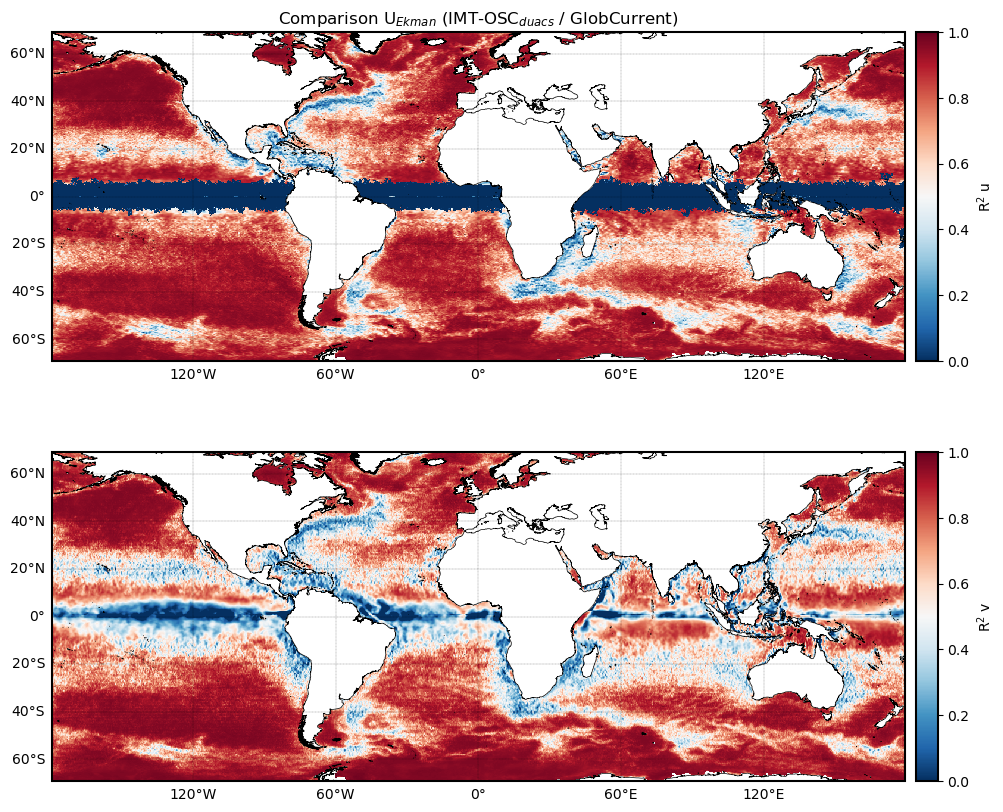

In [21]:
# Compare map 
import cartopy.crs as ccrs
fig, axs = plt.subplots(nrows=2,ncols=1,
                    subplot_kw={'projection': ccrs.PlateCarree()},
                    figsize=(11*1,5*2))

plot_uv_map(correlations_cyclo_u,imt.lon,imt.lat,lat_mask=None,vmin=0,vmax=1,colorbar_title="R$^{2}$ u",title="Comparison U$_{Ekman}$ (IMT-OSC$_{duacs}$ / GlobCurrent)",cmap=plt.cm.RdBu_r,fig=fig,axs=axs[0])
plot_uv_map(correlations_cyclo_v,imt.lon,imt.lat,lat_mask=None,vmin=0,vmax=1,colorbar_title="R$^{2}$ v",cmap=plt.cm.RdBu_r,fig=fig,axs=axs[1])
plt.savefig(f"../figures/correlation_Uekman_cyclo.png", dpi = 300)

In [ ]:
u_geo.shape

(560, 1440)

In [ ]:
# U - Ucyclo 
U_ekman_cyclo = imt.ugos - u_geo
# Calculer la corrélation le long de l'axe temporel (time)
correlations_cyclo = xr.corr(U_ekman_cyclo, gc.ue, dim='time')

In [ ]:
# Compare map 
plot_uv_map(correlations_cyclo,imt.lon,imt.lat,lat_mask=None,vmin=0,vmax=1,colorbar_title="R$^{2}$",title="Comparison U$_{Ekman}$ IMT-OSC$_{duacs}$ and GlobCurrent",cmap=plt.cm.hot_r)

Compute Beta et Theta ? 

In [ ]:
import numpy as np
from scipy.optimize import least_squares

# Données simulées (remplace par tes données)
u_ek = np.array([1+1j, 1.5+0.5j, 0.8+1.2j])  # Exemple de vecteur complexe
tau = np.array([1, 1, 1])  # Exemple de vecteur tau (remplace par tes données)

# Fonction de coût à minimiser
def cost_function(params, u_ek, tau):
    beta, theta = params
    model = beta * tau * np.exp(1j * theta)
    return np.abs(model - u_ek)  # Erreur quadratique sur les parties réelle et imaginaire

# Initialisation des paramètres
initial_params = np.array([1.0, 0.0])  # beta=1, theta=0

# Optimisation
result = least_squares(cost_function, initial_params, args=(u_ek, tau))
beta_hat, theta_hat = result.x

print(f"Estimation de beta: {beta_hat:.4f}")
print(f"Estimation de theta: {theta_hat:.4f} radians")